In [269]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float,
                 dim: int, n: int, seed: int):
        """ Class for pricing American OptionsLSM. 
        
        Parameters: 
        S0 (float): Initial asset value
        K (float): strike price
        T (float): time to maturity, in years, a float number
        r (float): risk-free interest rate
        σ (float): volatility coefficient for diffusion
        dim (int): number of paths to simulate
        n (int): between time 0 and time T, the number of time steps 
        """
        
        assert σ >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert n >= 0, 'no. of slices per year cannot be less than zero'
        assert dim >= 0, 'no. of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.dim = dim
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r*self.Δ)
        self.Z = np.random.normal(0, 1, (self.dim, self.n-1)) # white noise (drawn all at once)
        self.S = np.full((self.dim, self.n), np.nan)  # Allocate space for stock price process, with an extra step for initial value

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    def BS_option_value(self, otype: str = 'put'):
        ''' Closed-form valuation of a European option in Black-Scholes.
        
        Parameters:
        otype (str): Option type either call or put (defualt: put)
        
        Returns:
        float: Option price of a European put option
        '''
        
        # unpack 
        S0 = self.S0
        K = self.K
        r = self.r
        σ = self.σ
        T = self.T

        d1 = (np.log(S0/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)
        
        if otype == 'call':
            value = (S0 * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S0*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')
    
        return value
    
    def american_option_LSM(self, poly_degree: int, otype: str = 'put', print_paths=False):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # Initialize an array to store the exercise time for each path
        exercise_times = np.full(self.dim, self.n - 1)
        
        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1]) #If we go to last day, its just like an European, no "real" decision

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i]>0)  # evaluate: S[:,i] vs. K, so in-the-money paths
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            # Update the value function and exercise times
            exercise_now = self.intrinsic_val[:, i] > C
            exercise_times = np.where(exercise_now, i, exercise_times)
            V = np.where(exercise_now, self.intrinsic_val[:, i], V)

        # Optional: Print the value function for each path at this time step
        if print_paths:
            for path_index in range(min(self.dim, 10)):  # Limit to first 10 paths for readability
                print(f"Time {i}, Path {path_index + 1}: Value Function = {V[path_index]:.2f}, Exercise = {'Yes' if exercise_now[path_index] else 'No'}")
    
            # Calculate the option price
        self.V0 = self.df * np.mean(V)
        return self.V0, exercise_times

    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()

In [265]:
# Initialize the Monte Carlo option pricing with a specific seed
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=6., K=6., T=3, σ=0.25, dim=1, n=20, seed=3)

# Generate 'dim' no. of stock price process paths
#simulated_paths = mc_option_pricing.GeometricBrownianMotion()
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
#simulated_paths = mc_option_pricing.MertonJumpDiffusion(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.MertonJumpDiffusion_vec(α=-0.5,β=0.4,λ=0.4)
#simulated_paths = mc_option_pricing.CEV(γ=1.5)

# plot stock price process
#mc_option_pricing.plot_paths() 


In [266]:
mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')

(0.27796609182281423, array([8]))

In [267]:
mc_option_pricing.BS_option_value(otype='put')

0.52841522491004

Hvis v

Det kan kontrolleres nu! Nu skal vi manuelt indsætte optimale exercise times.

Hvis vi kan skifte tau nedenunder ud med at den tager input fra optimal exercise times, så er det rigtig godt

C:\Users\user\AppData\Local\Temp\ipykernel_1392\178126213.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  var_ratio = np.var(American_Put_Payoffs) / np.var(Y)


Correlation of payoffs: 1.0
Control variate price estimate: 0.3522768166066932
Variance ratio of payoffs (varAmericanPutPayoff/Var(Y)): inf


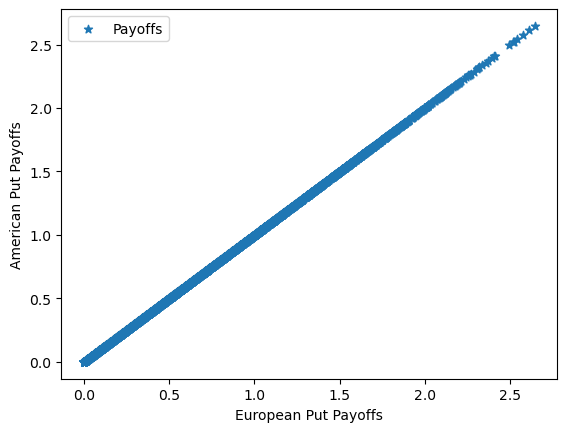

American payoff
[0.2941381  0.48718526 0.83422329 ... 0.35074632 0.         0.63413095]
break
break
break
break
break
break
European payoff
[0.2941381  0.48718526 0.83422329 ... 0.35074632 0.         0.63413095]
Control mean: 0.3470469899103943
BS price: 0.3522768166066932
American mean: 0.3470469899103943


In [270]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Inputs
n = 10000 # number of simulations
T = 3   # time to maturity
tau = 3 # optimal
M = 250     # number of time steps
sigma = 0.25  # volatility
K = 4    # strike price
r = 0.06  # risk-free rate
S0 = 4    # initial stock price
np.random.seed(3)


# Simulation of GBM
#Z = np.random.normal(0, 1, size=(n, M))
#S = S0 * np.exp(np.cumsum((r - 0.5 * sigma**2) * (T / M) + sigma * np.sqrt(T / M) * Z, axis=1))
# Initialize the MonteCarloOptionPricing class and simulate GBM
# American and European Put Payoffs
# Initialize the Monte Carlo option pricing class
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, sigma, n, M, seed=15)

# Generate stock price paths
S = mc_option_pricing.GeometricBrownianMotion_vec()

# Apply LSM method for American options
american_option_price, exercise_times = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Calculate American put payoffs using the optimal stopping times
American_Put_Payoffs = np.exp(-r * T) * np.maximum(K - S[:, -1], 0)
European_Put_Payoffs = np.exp(-r * T) * np.maximum(K - S[:, -1], 0)

# Estimate prices by crude Monte Carlo
American_PriceEst = np.mean(American_Put_Payoffs)
European_PriceEst = np.mean(European_Put_Payoffs)

# Control mean (Calculated using Black-Scholes)
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
Control_Mean = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's using control variate technique
covariance = np.cov(American_Put_Payoffs, European_Put_Payoffs, ddof=0)
alfa = -covariance[0, 1] / covariance[1, 1]
Y = American_Put_Payoffs + alfa * (European_Put_Payoffs - Control_Mean)

# Price estimate using control variate
Control_Variate_PriceEst = np.mean(Y)

# Prints correlation coefficient and variance ratio
rho = np.corrcoef(American_Put_Payoffs, European_Put_Payoffs)[0, 1]
var_ratio = np.var(American_Put_Payoffs) / np.var(Y)

print(f'Correlation of payoffs: {rho}')
print(f'Control variate price estimate: {Control_Variate_PriceEst}')
print(f'Variance ratio of payoffs (varAmericanPutPayoff/Var(Y)): {var_ratio}')

# Plots payoffs to show correlation
plt.scatter(European_Put_Payoffs, American_Put_Payoffs, marker='*', label='Payoffs')
plt.xlabel('European Put Payoffs')
plt.ylabel('American Put Payoffs')
plt.legend()
plt.show()

print("American payoff")
print(American_Put_Payoffs)
print("break")
print("break")
print("break")
print("break")
print("break")
print("break")
print("European payoff")
print(European_Put_Payoffs)
print("Control mean:", European_PriceEst)
print("BS price:", Control_Mean)
print("American mean:", American_PriceEst)